In [83]:
import cv2 
import pickle
import matplotlib.pyplot as plt

In [84]:
cv2.imread("/Users/sanskarsoni/Downloads/data_animals/animals/animals/antelope/0a37838e99.jpg",0)

array([[125, 124, 125, ..., 143, 143, 144],
       [131, 129, 128, ..., 146, 145, 145],
       [133, 132, 129, ..., 146, 144, 143],
       ...,
       [108, 109, 112, ..., 127, 134, 144],
       [113, 111, 111, ..., 130, 138, 147],
       [118, 113, 110, ..., 132, 138, 144]], dtype=uint8)

## Resize Images function

In [85]:
# Resize images to a similar dimension
# This helps improve accuracy and decreases unnecessarily high number of keypoints

def imageResizeTrain(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def imageResizeTest(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

# Generate Keypoint and Descriptors

In [86]:

imageList = ["antelope/0b1a3af197.jpg","antelope/0b688923b0.jpg","antelope/1a3f59ee02.jpg","bat/1fd53c0b98.jpg","boar/3c34dc709e.jpg"]

In [87]:
imagesBW = []
for imageName in imageList:
    imagePath = "/Users/sanskarsoni/Downloads/data_animals/animals/animals/" + str(imageName)
    imagesBW.append(imageResizeTrain(cv2.imread(imagePath,0))) # flag 0 means grayscale

# Using OPenCV SIFT

In [88]:
sift = cv2.SIFT_create()

def computeSIFT(image):
    return sift.detectAndCompute(image, None)

In [89]:
keypoints = []
descriptors = []
for i,image in enumerate(imagesBW):
    print("Starting for image: " + imageList[i])
    keypointTemp, descriptorTemp = computeSIFT(image)
    keypoints.append(keypointTemp)
    descriptors.append(descriptorTemp)
    print("  Ending for image: " + imageList[i])

Starting for image: antelope/0b1a3af197.jpg
  Ending for image: antelope/0b1a3af197.jpg
Starting for image: antelope/0b688923b0.jpg
  Ending for image: antelope/0b688923b0.jpg
Starting for image: antelope/1a3f59ee02.jpg
  Ending for image: antelope/1a3f59ee02.jpg
Starting for image: bat/1fd53c0b98.jpg
  Ending for image: bat/1fd53c0b98.jpg
Starting for image: boar/3c34dc709e.jpg
  Ending for image: boar/3c34dc709e.jpg


# Store Keypoints and Descriptors for future use

In [90]:
for i,keypoint in enumerate(keypoints):
    deserializedKeypoints = []
    print(imageList[i].split(".")[0].split('/')[1])
    filepath = "features/" + str(imageList[i].split(".")[0].split('/')[1]) + ".txt"
    print(filepath)
    for point in keypoint:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        deserializedKeypoints.append(temp)
    with open(filepath, 'wb') as fp:
        pickle.dump(deserializedKeypoints, fp) 

0b1a3af197
features/0b1a3af197.txt
0b688923b0
features/0b688923b0.txt
1a3f59ee02
features/1a3f59ee02.txt
1fd53c0b98
features/1fd53c0b98.txt
3c34dc709e
features/3c34dc709e.txt


In [91]:
for i,descriptor in enumerate(descriptors):
    filepath = "descriptors/" + str(imageList[i].split(".")[0].split('/')[1]) + ".txt"
    with open(filepath, 'wb') as fp:
        pickle.dump(descriptor, fp)

# Fetch Keypoints and Descriptors from stored files

In [92]:
def fetchKeypointFromFile(i):
    filepath = "features/" + str(imageList[i].split(".")[0].split('/')[1]) + ".txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(
            x=point[0][0],
            y=point[0][1],
            size=point[1],
            angle=point[2],
            response=point[3],
            octave=point[4],
            class_id=point[5]
        )
        keypoint.append(temp)
    return keypoint

In [93]:
def fetchDescriptorFromFile(i):
    filepath = "descriptors/" + str(imageList[i].split(".")[0].split('/')[1]) + ".txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

# Calculate Results for any pair

In [94]:
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    print(len(matches),len(keypoint1),len(keypoint2),len(descriptor1),len(descriptor2))
    print(score)
    plt.imshow(plot),plt.show()

In [95]:
def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeTest(cv2.imread("/Users/sanskarsoni/Downloads/data_animals/animals/animals/" + imageList[i]))
    image2 = imageResizeTest(cv2.imread("/Users/sanskarsoni/Downloads/data_animals/animals/animals/" + imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

In [96]:
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

In [113]:
bf = cv2.BFMatcher()
def calculateMatches(des1,des2):
    matches = bf.knnMatch(des1,des2,k=2)
    topResults1 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults1.append([m])
            
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults2.append([m])
    
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults

In [116]:
def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        [255,255,255],
        flags=2
    )
    return matchPlot

0 1549 815 1549 815
0.0


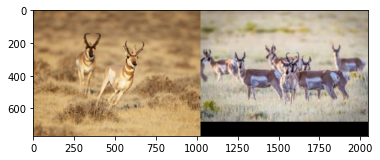

In [121]:
calculateResultsFor(1,2)

In [122]:
## HELPFUL FOR EXACT MATCH DUPLICATE ASSET DETECTION